In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
from scipy import stats # Import the stats module from SciPy

In [2]:
# --- 1. Configuration ---
TRAIN_SPLIT_RATIO = 0.9
BATCH_SIZE = 128
INNER_LR = 1e-3
OUTER_LR = 1e-3
META_STEPS = 1000
INNER_STEPS = 2  # T: Number of steps for the inner loop
META_REFRESH_STEPS = 10  # N: Number of steps to refresh the inner model
GRAD_CLIP_NORM = 1.0
NUM_INNER_MODELS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

# --- 3. Model Definitions ---
class ToyCNN(nn.Module):
    """The inner model that gets trained on re-weighted data."""
    def __init__(self):
        super(ToyCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        return self.layers(x)

class DataRater(nn.Module):
    """The outer model (meta-learner) that learns to rate data."""
    def __init__(self, temperature=1.0):
        super(DataRater, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.head = nn.Linear(400, 1)
        self.temperature = temperature

    def forward(self, x):
        features = self.layers(x)
        return self.head(features).squeeze(-1)

In [4]:
# --- 2. Data Pipeline ---
def get_mnist_loaders(batch_size, train_split_ratio):
    """Prepares the MNIST train, validation, and test data loaders."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create a train/validation split
    num_train = int(len(train_dataset) * train_split_ratio)
    num_val = len(train_dataset) - num_train
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [num_train, num_val])

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:
def inner_loop_step(inner_model, inner_optimizer, data_rater, inner_batch):
    """
    Performs a single training step for the inner model.
    """
    inner_model.train()
    data_rater.train()

    inner_images, inner_labels = inner_batch
    inner_images, inner_labels = inner_images.to(DEVICE), inner_labels.to(DEVICE)

    # Zero gradients for the inner optimizer
    inner_optimizer.zero_grad()

    # Get ratings and compute weights for the current batch
    with torch.no_grad(): # Don't track gradients for data rater here
        ratings = data_rater(inner_images)
        weights = torch.softmax(ratings, dim=0)

    # Get predictions from the inner model
    logits = inner_model(inner_images)

    # Calculate per-sample cross-entropy loss and apply weights
    per_sample_losses = nn.functional.cross_entropy(logits, inner_labels, reduction='none')
    weighted_loss = (per_sample_losses * weights).mean()

    # Update the inner model
    weighted_loss.backward()
    torch.nn.utils.clip_grad_norm_(inner_model.parameters(), GRAD_CLIP_NORM)
    inner_optimizer.step()

In [6]:
def outer_loop_step(data_rater, outer_optimizer, inner_models, inner_optimizers, train_iterator, val_iterator, train_loader, val_loader):
    """
    Performs one full meta-update step using a provided POPULATION of inner models.
    """
    # --- 1. Run the inner loop for each model in the provided population ---
    for model, optimizer in zip(inner_models, inner_optimizers):
        for _ in range(INNER_STEPS):
            try:
                inner_batch = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_loader)
                inner_batch = next(train_iterator)

            inner_loop_step(model, optimizer, data_rater, inner_batch)

    # --- 2. Perform the outer update on the DataRater ---
    data_rater.train()
    for model in inner_models:
        model.eval()

    # Get a single outer batch to evaluate all models
    try:
        outer_images, outer_labels = next(val_iterator)
    except StopIteration:
        val_iterator = iter(val_loader)
        outer_images, outer_labels = next(val_iterator)
    outer_images, outer_labels = outer_images.to(DEVICE), outer_labels.to(DEVICE)

    # --- 3. Calculate and average the outer loss across the population ---
    outer_losses = []
    for model in inner_models:
        outer_logits = model(outer_images)
        outer_loss = nn.functional.cross_entropy(outer_logits, outer_labels)
        outer_losses.append(outer_loss)

    average_outer_loss = torch.mean(torch.stack(outer_losses))

    # --- 4. Update the DataRater using the averaged loss ---
    outer_optimizer.zero_grad()
    average_outer_loss.backward()
    torch.nn.utils.clip_grad_norm_(data_rater.parameters(), GRAD_CLIP_NORM)
    outer_optimizer.step()

    return average_outer_loss.item()

In [14]:
def run_meta_training(visualize_progress=False):
    """
    Initializes models and orchestrates the main meta-training loop.
    Manages a population of inner models and refreshes them periodically.
    """
    # --- Initial Setup ---
    data_rater = DataRater().to(DEVICE)
    outer_optimizer = optim.Adam(data_rater.parameters(), lr=OUTER_LR)

    train_loader, val_loader, test_loader = get_mnist_loaders(BATCH_SIZE, TRAIN_SPLIT_RATIO)
    train_iterator = iter(train_loader)
    val_iterator = iter(val_loader)

    # Declare lists for the population of inner models and optimizers
    inner_models, inner_optimizers = None, None

    print(f"Starting meta-training with a population of {NUM_INNER_MODELS} models, refreshing every {META_REFRESH_STEPS} steps.")

    # --- The Main Training Loop ---
    for meta_step in tqdm(range(META_STEPS), desc="Meta-Training"):
        # Periodically refresh the entire population of inner models
        if meta_step % META_REFRESH_STEPS == 0:
            tqdm.write(f"\n[Meta-Step {meta_step}] Refreshing inner model population...")
            inner_models = [ToyCNN().to(DEVICE) for _ in range(NUM_INNER_MODELS)]
            inner_optimizers = [optim.Adam(model.parameters(), lr=INNER_LR) for model in inner_models]

        # Pass the current population of models and optimizers to the step function
        outer_loss = outer_loop_step(
            data_rater, outer_optimizer,
            inner_models, inner_optimizers,  # Pass the lists
            train_iterator, val_iterator,
            train_loader, val_loader
        )

        if (meta_step + 1) % 10 == 0:
            tqdm.write(f"  [Meta-Step {meta_step + 1}/{META_STEPS}] Outer Loss: {outer_loss:.4f}")

        # Periodic visualization logic remains the same
        if visualize_progress and (meta_step + 1) % 100 == 0:
            analyze_with_individual_corruption(
                data_rater,
                test_loader,
                num_batches=5,
                current_step=meta_step + 1
            )

    print("\n✅ Training complete!")
    return data_rater

In [15]:
def corrupt_images(images, corruption_fraction):
    """
    Corrupts a batch of images by REPLACING a fraction of pixels with random noise.
    Args:
        images (torch.Tensor): A batch of images (B, C, H, W).
        corruption_fraction (float): The fraction of pixels to corrupt (0.0 to 1.0).
    Returns:
        torch.Tensor: The batch of corrupted images.
    """
    if corruption_fraction == 0.0:
        return images

    corrupted_images = images.clone()
    batch_size, _, height, width = images.shape
    num_pixels_total = height * width
    num_pixels_to_corrupt = int(corruption_fraction * num_pixels_total)

    for i in range(batch_size):
        # Generate a random permutation of pixel indices to corrupt
        indices = torch.randperm(num_pixels_total, device=images.device)[:num_pixels_to_corrupt]

        # Convert flat indices to 2D indices
        row_indices = indices // width
        col_indices = indices % width

        # --- Generate random pixel values to replace the existing ones ---
        # Values are from a uniform distribution across the full [-1, 1] range.
        random_pixels = torch.rand(num_pixels_to_corrupt, device=images.device) * 2 - 1

        # --- Place the new random pixels into the image ---
        corrupted_images[i, 0, row_indices, col_indices] = random_pixels

    return corrupted_images

In [16]:
def analyze_with_individual_corruption(data_rater, data_loader, num_batches=5, current_step=None):
    """
    Analyzes the DataRater by corrupting each image with a continuous random
    fraction and creating a scatter plot of scores vs. corruption.
    """
    print(f"\n--- Analyzing with Continuous Individual Corruption over {num_batches} batches --- MetaStep: {current_step}")
    data_rater.eval()  # Set the model to evaluation mode

    # These master lists will store the results from all batches
    all_scores = []
    all_fractions = []

    # Loop over the specified number of batches
    for i, (batch_images, _) in enumerate(data_loader):
        if i >= num_batches:
            break

        batch_images = batch_images.to(DEVICE)
        batch_size = batch_images.size(0)

        individually_corrupted_batch = torch.zeros_like(batch_images)
        fractions_for_this_batch = []

        # Corrupt each image in the batch one by one
        for j in range(batch_size):
            # --- NEW: Generate a continuous random fraction between 0.0 and 1.0 ---
            frac = np.random.uniform(0.0, 1.0)
            fractions_for_this_batch.append(frac)

            # Corrupt the single image (note: we keep the batch dimension)
            original_image = batch_images[j:j+1]
            corrupted_image = corrupt_images(original_image, frac)
            individually_corrupted_batch[j] = corrupted_image

        # Get the model's scores for the entire batch of individually corrupted images
        with torch.no_grad():
            scores = data_rater(individually_corrupted_batch)
            weights = torch.softmax(scores, dim=0)

        # Append the results to our master lists
        all_scores.extend(weights.cpu().numpy())
        all_fractions.extend(fractions_for_this_batch)

    # --- Plotting and Regression Analysis ---

    plt.figure(figsize=(12, 8))

    # Scatter plot with continuous x-axis values (jitter is no longer needed)
    plt.scatter(all_fractions, all_scores, alpha=0.3, label='Individual Image Score')

    # Perform and plot the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_fractions, all_scores)
    r_squared = r_value**2

    x_line = np.array([min(all_fractions), max(all_fractions)])
    y_line = slope * x_line + intercept

    plt.plot(x_line, y_line,
             color='red', linewidth=2,
             label=f'Linear Regression (R² = {r_squared:.3f})')

    plt.title('DataRater Score vs. Individual Image Corruption', fontsize=16)
    plt.xlabel('Fraction of Corrupted Pixels')
    plt.ylabel('Raw Score (Rating)')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.show()

In [17]:
def visualize_corruption(data_rater, data_loader, num_images=5):
    """
    Selects images, displays them with varying corruption, and overlays the
    DataRater's score on each image.
    """
    print("\n--- Visualizing Image Corruption with DataRater Scores ---")

    # Ensure the model is on the correct device and in evaluation mode
    data_rater.to(DEVICE).eval()

    # Get a single batch of images
    sample_images, _ = next(iter(data_loader))

    corruption_fractions = [0.0, 0.25, 0.5, 0.75, 1.0]

    fig, axes = plt.subplots(num_images, len(corruption_fractions), figsize=(12, num_images * 2.2))

    for i in range(num_images):
        original_image = sample_images[i:i+1]  # Keep batch dim

        for j, frac in enumerate(corruption_fractions):
            ax = axes[i, j]

            # Create the corrupted version
            corrupted_image_tensor = corrupt_images(original_image, frac)

            # --- Get the DataRater's score for this specific image ---
            with torch.no_grad():
                score = data_rater(corrupted_image_tensor.to(DEVICE)).item()

            # Prepare image for plotting (denormalize, etc.)
            img_to_plot = corrupted_image_tensor.squeeze().cpu().numpy()
            img_to_plot = img_to_plot * 0.5 + 0.5

            ax.imshow(img_to_plot, cmap='gray')
            ax.axis('off')

            # --- Add the score as text onto the image ---
            # The text is placed at coordinates (x=2, y=26) on the image
            txt = ax.text(2, 26, f"{score:.3f}",
                          color='white', fontsize=11, fontweight='bold')
            # Add a black outline to the text for high visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

            if i == 0:
                ax.set_title(f"{frac*100:.0f}% Noise")

    fig.suptitle('Sample Images with DataRater Scores', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [22]:
# --- 6. Main Execution ---
if __name__ == "__main__":
    trained_data_rater = run_meta_training(visualize_progress=False)

    # Get a test loader for the analysis phase
    _, _, test_loader = get_mnist_loaders(BATCH_SIZE, TRAIN_SPLIT_RATIO)

Starting meta-training with a population of 4 models, refreshing every 10 steps.


Meta-Training:   0%|          | 0/1000 [00:00<?, ?it/s]


[Meta-Step 0] Refreshing inner model population...


Meta-Training:   1%|          | 10/1000 [00:04<05:18,  3.10it/s]

  [Meta-Step 10/1000] Outer Loss: 1.2252

[Meta-Step 10] Refreshing inner model population...


Meta-Training:   2%|▏         | 20/1000 [00:06<04:13,  3.87it/s]

  [Meta-Step 20/1000] Outer Loss: 1.2765

[Meta-Step 20] Refreshing inner model population...


Meta-Training:   3%|▎         | 30/1000 [00:09<04:01,  4.01it/s]

  [Meta-Step 30/1000] Outer Loss: 1.2475

[Meta-Step 30] Refreshing inner model population...


Meta-Training:   4%|▍         | 40/1000 [00:11<04:01,  3.97it/s]

  [Meta-Step 40/1000] Outer Loss: 1.3102

[Meta-Step 40] Refreshing inner model population...


Meta-Training:   5%|▌         | 50/1000 [00:14<05:01,  3.15it/s]

  [Meta-Step 50/1000] Outer Loss: 1.2160

[Meta-Step 50] Refreshing inner model population...


Meta-Training:   6%|▌         | 60/1000 [00:17<04:05,  3.82it/s]

  [Meta-Step 60/1000] Outer Loss: 1.3799

[Meta-Step 60] Refreshing inner model population...


Meta-Training:   7%|▋         | 70/1000 [00:19<03:56,  3.93it/s]

  [Meta-Step 70/1000] Outer Loss: 1.3407

[Meta-Step 70] Refreshing inner model population...


Meta-Training:   8%|▊         | 80/1000 [00:22<03:48,  4.03it/s]

  [Meta-Step 80/1000] Outer Loss: 1.2514

[Meta-Step 80] Refreshing inner model population...


Meta-Training:   9%|▉         | 90/1000 [00:24<03:49,  3.97it/s]

  [Meta-Step 90/1000] Outer Loss: 1.1847

[Meta-Step 90] Refreshing inner model population...


Meta-Training:  10%|█         | 100/1000 [00:28<04:52,  3.07it/s]

  [Meta-Step 100/1000] Outer Loss: 1.2698

[Meta-Step 100] Refreshing inner model population...


Meta-Training:  11%|█         | 110/1000 [00:30<03:49,  3.87it/s]

  [Meta-Step 110/1000] Outer Loss: 1.3049

[Meta-Step 110] Refreshing inner model population...


Meta-Training:  12%|█▏        | 120/1000 [00:33<03:42,  3.95it/s]

  [Meta-Step 120/1000] Outer Loss: 1.2598

[Meta-Step 120] Refreshing inner model population...


Meta-Training:  13%|█▎        | 130/1000 [00:35<03:36,  4.01it/s]

  [Meta-Step 130/1000] Outer Loss: 1.1874

[Meta-Step 130] Refreshing inner model population...


Meta-Training:  14%|█▍        | 140/1000 [00:38<04:14,  3.38it/s]

  [Meta-Step 140/1000] Outer Loss: 1.3439

[Meta-Step 140] Refreshing inner model population...


Meta-Training:  15%|█▌        | 150/1000 [00:41<03:45,  3.77it/s]

  [Meta-Step 150/1000] Outer Loss: 1.3176

[Meta-Step 150] Refreshing inner model population...


Meta-Training:  16%|█▌        | 160/1000 [00:43<03:31,  3.97it/s]

  [Meta-Step 160/1000] Outer Loss: 1.3310

[Meta-Step 160] Refreshing inner model population...


Meta-Training:  17%|█▋        | 170/1000 [00:46<03:34,  3.87it/s]

  [Meta-Step 170/1000] Outer Loss: 1.3237

[Meta-Step 170] Refreshing inner model population...


Meta-Training:  18%|█▊        | 180/1000 [00:49<03:31,  3.87it/s]

  [Meta-Step 180/1000] Outer Loss: 1.2518

[Meta-Step 180] Refreshing inner model population...


Meta-Training:  19%|█▉        | 190/1000 [00:52<04:27,  3.03it/s]

  [Meta-Step 190/1000] Outer Loss: 1.4722

[Meta-Step 190] Refreshing inner model population...


Meta-Training:  20%|██        | 200/1000 [00:54<03:23,  3.92it/s]

  [Meta-Step 200/1000] Outer Loss: 1.2756

[Meta-Step 200] Refreshing inner model population...


Meta-Training:  21%|██        | 210/1000 [00:57<03:19,  3.95it/s]

  [Meta-Step 210/1000] Outer Loss: 1.3582

[Meta-Step 210] Refreshing inner model population...


Meta-Training:  22%|██▏       | 220/1000 [01:00<03:22,  3.84it/s]

  [Meta-Step 220/1000] Outer Loss: 1.2087

[Meta-Step 220] Refreshing inner model population...


Meta-Training:  23%|██▎       | 230/1000 [01:02<04:00,  3.20it/s]

  [Meta-Step 230/1000] Outer Loss: 1.3358

[Meta-Step 230] Refreshing inner model population...


Meta-Training:  24%|██▍       | 240/1000 [01:05<03:21,  3.78it/s]

  [Meta-Step 240/1000] Outer Loss: 1.3353

[Meta-Step 240] Refreshing inner model population...


Meta-Training:  25%|██▌       | 250/1000 [01:08<03:07,  4.00it/s]

  [Meta-Step 250/1000] Outer Loss: 1.3633

[Meta-Step 250] Refreshing inner model population...


Meta-Training:  26%|██▌       | 260/1000 [01:10<03:10,  3.89it/s]

  [Meta-Step 260/1000] Outer Loss: 1.2757

[Meta-Step 260] Refreshing inner model population...


Meta-Training:  27%|██▋       | 270/1000 [01:13<03:16,  3.71it/s]

  [Meta-Step 270/1000] Outer Loss: 1.3047

[Meta-Step 270] Refreshing inner model population...


Meta-Training:  28%|██▊       | 280/1000 [01:16<03:45,  3.20it/s]

  [Meta-Step 280/1000] Outer Loss: 1.3986

[Meta-Step 280] Refreshing inner model population...


Meta-Training:  29%|██▉       | 290/1000 [01:19<03:04,  3.84it/s]

  [Meta-Step 290/1000] Outer Loss: 1.2792

[Meta-Step 290] Refreshing inner model population...


Meta-Training:  30%|███       | 300/1000 [01:21<02:57,  3.94it/s]

  [Meta-Step 300/1000] Outer Loss: 1.2638

[Meta-Step 300] Refreshing inner model population...


Meta-Training:  31%|███       | 310/1000 [01:24<02:55,  3.93it/s]

  [Meta-Step 310/1000] Outer Loss: 1.4161

[Meta-Step 310] Refreshing inner model population...


Meta-Training:  32%|███▏      | 320/1000 [01:27<03:37,  3.12it/s]

  [Meta-Step 320/1000] Outer Loss: 1.2583

[Meta-Step 320] Refreshing inner model population...


Meta-Training:  33%|███▎      | 330/1000 [01:30<03:02,  3.66it/s]

  [Meta-Step 330/1000] Outer Loss: 1.2914

[Meta-Step 330] Refreshing inner model population...


Meta-Training:  34%|███▍      | 340/1000 [01:33<02:53,  3.80it/s]

  [Meta-Step 340/1000] Outer Loss: 1.1704

[Meta-Step 340] Refreshing inner model population...


Meta-Training:  35%|███▌      | 350/1000 [01:35<02:49,  3.83it/s]

  [Meta-Step 350/1000] Outer Loss: 1.2530

[Meta-Step 350] Refreshing inner model population...


Meta-Training:  36%|███▌      | 360/1000 [01:38<02:39,  4.02it/s]

  [Meta-Step 360/1000] Outer Loss: 1.2110

[Meta-Step 360] Refreshing inner model population...


Meta-Training:  37%|███▋      | 370/1000 [01:41<03:10,  3.31it/s]

  [Meta-Step 370/1000] Outer Loss: 1.3181

[Meta-Step 370] Refreshing inner model population...


Meta-Training:  38%|███▊      | 380/1000 [01:43<02:38,  3.92it/s]

  [Meta-Step 380/1000] Outer Loss: 1.2886

[Meta-Step 380] Refreshing inner model population...


Meta-Training:  39%|███▉      | 390/1000 [01:46<02:35,  3.93it/s]

  [Meta-Step 390/1000] Outer Loss: 1.1778

[Meta-Step 390] Refreshing inner model population...


Meta-Training:  40%|████      | 400/1000 [01:49<02:29,  4.00it/s]

  [Meta-Step 400/1000] Outer Loss: 1.3297

[Meta-Step 400] Refreshing inner model population...


Meta-Training:  41%|████      | 410/1000 [01:51<03:01,  3.25it/s]

  [Meta-Step 410/1000] Outer Loss: 1.3483

[Meta-Step 410] Refreshing inner model population...


Meta-Training:  42%|████▏     | 420/1000 [01:54<02:28,  3.91it/s]

  [Meta-Step 420/1000] Outer Loss: 1.3063

[Meta-Step 420] Refreshing inner model population...


Meta-Training:  43%|████▎     | 430/1000 [01:57<02:21,  4.01it/s]

  [Meta-Step 430/1000] Outer Loss: 1.2089

[Meta-Step 430] Refreshing inner model population...


Meta-Training:  44%|████▍     | 440/1000 [01:59<02:24,  3.87it/s]

  [Meta-Step 440/1000] Outer Loss: 1.1783

[Meta-Step 440] Refreshing inner model population...


Meta-Training:  45%|████▌     | 450/1000 [02:02<02:23,  3.84it/s]

  [Meta-Step 450/1000] Outer Loss: 1.3015

[Meta-Step 450] Refreshing inner model population...


Meta-Training:  46%|████▌     | 460/1000 [02:05<02:41,  3.34it/s]

  [Meta-Step 460/1000] Outer Loss: 1.2200

[Meta-Step 460] Refreshing inner model population...


Meta-Training:  47%|████▋     | 470/1000 [02:07<02:12,  3.99it/s]

  [Meta-Step 470/1000] Outer Loss: 1.3417

[Meta-Step 470] Refreshing inner model population...


Meta-Training:  48%|████▊     | 480/1000 [02:10<02:10,  3.99it/s]

  [Meta-Step 480/1000] Outer Loss: 1.2576

[Meta-Step 480] Refreshing inner model population...


Meta-Training:  49%|████▉     | 490/1000 [02:13<02:08,  3.98it/s]

  [Meta-Step 490/1000] Outer Loss: 1.3337

[Meta-Step 490] Refreshing inner model population...


Meta-Training:  50%|█████     | 500/1000 [02:15<02:41,  3.10it/s]

  [Meta-Step 500/1000] Outer Loss: 1.2473

[Meta-Step 500] Refreshing inner model population...


Meta-Training:  51%|█████     | 510/1000 [02:18<02:07,  3.84it/s]

  [Meta-Step 510/1000] Outer Loss: 1.2780

[Meta-Step 510] Refreshing inner model population...


Meta-Training:  52%|█████▏    | 520/1000 [02:21<02:03,  3.90it/s]

  [Meta-Step 520/1000] Outer Loss: 1.3480

[Meta-Step 520] Refreshing inner model population...


Meta-Training:  53%|█████▎    | 530/1000 [02:23<02:01,  3.86it/s]

  [Meta-Step 530/1000] Outer Loss: 1.2572

[Meta-Step 530] Refreshing inner model population...


Meta-Training:  54%|█████▍    | 540/1000 [02:26<01:57,  3.92it/s]

  [Meta-Step 540/1000] Outer Loss: 1.2217

[Meta-Step 540] Refreshing inner model population...


Meta-Training:  55%|█████▌    | 550/1000 [02:29<02:21,  3.17it/s]

  [Meta-Step 550/1000] Outer Loss: 1.2431

[Meta-Step 550] Refreshing inner model population...


Meta-Training:  56%|█████▌    | 560/1000 [02:32<01:50,  3.97it/s]

  [Meta-Step 560/1000] Outer Loss: 1.2318

[Meta-Step 560] Refreshing inner model population...


Meta-Training:  57%|█████▋    | 570/1000 [02:34<01:49,  3.92it/s]

  [Meta-Step 570/1000] Outer Loss: 1.4095

[Meta-Step 570] Refreshing inner model population...


Meta-Training:  58%|█████▊    | 580/1000 [02:37<01:47,  3.92it/s]

  [Meta-Step 580/1000] Outer Loss: 1.3376

[Meta-Step 580] Refreshing inner model population...


Meta-Training:  59%|█████▉    | 590/1000 [02:40<02:08,  3.18it/s]

  [Meta-Step 590/1000] Outer Loss: 1.3689

[Meta-Step 590] Refreshing inner model population...


Meta-Training:  60%|██████    | 600/1000 [02:42<01:41,  3.94it/s]

  [Meta-Step 600/1000] Outer Loss: 1.3203

[Meta-Step 600] Refreshing inner model population...


Meta-Training:  61%|██████    | 610/1000 [02:45<01:38,  3.96it/s]

  [Meta-Step 610/1000] Outer Loss: 1.2806

[Meta-Step 610] Refreshing inner model population...


Meta-Training:  62%|██████▏   | 620/1000 [02:47<01:33,  4.05it/s]

  [Meta-Step 620/1000] Outer Loss: 1.2921

[Meta-Step 620] Refreshing inner model population...


Meta-Training:  63%|██████▎   | 630/1000 [02:50<01:31,  4.02it/s]

  [Meta-Step 630/1000] Outer Loss: 1.3544

[Meta-Step 630] Refreshing inner model population...


Meta-Training:  64%|██████▍   | 640/1000 [02:53<02:05,  2.88it/s]

  [Meta-Step 640/1000] Outer Loss: 1.2332

[Meta-Step 640] Refreshing inner model population...


Meta-Training:  65%|██████▌   | 650/1000 [02:56<01:27,  3.98it/s]

  [Meta-Step 650/1000] Outer Loss: 1.1420

[Meta-Step 650] Refreshing inner model population...


Meta-Training:  66%|██████▌   | 660/1000 [02:58<01:23,  4.06it/s]

  [Meta-Step 660/1000] Outer Loss: 1.3340

[Meta-Step 660] Refreshing inner model population...


Meta-Training:  67%|██████▋   | 670/1000 [03:01<01:22,  3.99it/s]

  [Meta-Step 670/1000] Outer Loss: 1.2992

[Meta-Step 670] Refreshing inner model population...


Meta-Training:  68%|██████▊   | 680/1000 [03:03<01:21,  3.95it/s]

  [Meta-Step 680/1000] Outer Loss: 1.2073

[Meta-Step 680] Refreshing inner model population...


Meta-Training:  69%|██████▉   | 690/1000 [03:06<01:24,  3.66it/s]

  [Meta-Step 690/1000] Outer Loss: 1.3256

[Meta-Step 690] Refreshing inner model population...


Meta-Training:  70%|███████   | 700/1000 [03:09<01:17,  3.88it/s]

  [Meta-Step 700/1000] Outer Loss: 1.1622

[Meta-Step 700] Refreshing inner model population...


Meta-Training:  71%|███████   | 710/1000 [03:11<01:11,  4.04it/s]

  [Meta-Step 710/1000] Outer Loss: 1.2255

[Meta-Step 710] Refreshing inner model population...


Meta-Training:  72%|███████▏  | 720/1000 [03:14<01:09,  4.05it/s]

  [Meta-Step 720/1000] Outer Loss: 1.2140

[Meta-Step 720] Refreshing inner model population...


Meta-Training:  73%|███████▎  | 730/1000 [03:17<01:26,  3.11it/s]

  [Meta-Step 730/1000] Outer Loss: 1.2968

[Meta-Step 730] Refreshing inner model population...


Meta-Training:  74%|███████▍  | 740/1000 [03:19<01:07,  3.86it/s]

  [Meta-Step 740/1000] Outer Loss: 1.1084

[Meta-Step 740] Refreshing inner model population...


Meta-Training:  75%|███████▌  | 750/1000 [03:22<01:01,  4.06it/s]

  [Meta-Step 750/1000] Outer Loss: 1.2918

[Meta-Step 750] Refreshing inner model population...


Meta-Training:  76%|███████▌  | 760/1000 [03:24<01:01,  3.93it/s]

  [Meta-Step 760/1000] Outer Loss: 1.4601

[Meta-Step 760] Refreshing inner model population...


Meta-Training:  77%|███████▋  | 770/1000 [03:27<00:55,  4.11it/s]

  [Meta-Step 770/1000] Outer Loss: 1.3336

[Meta-Step 770] Refreshing inner model population...


Meta-Training:  78%|███████▊  | 780/1000 [03:30<01:06,  3.33it/s]

  [Meta-Step 780/1000] Outer Loss: 1.2617

[Meta-Step 780] Refreshing inner model population...


Meta-Training:  79%|███████▉  | 790/1000 [03:32<00:52,  4.01it/s]

  [Meta-Step 790/1000] Outer Loss: 1.2291

[Meta-Step 790] Refreshing inner model population...


Meta-Training:  80%|████████  | 800/1000 [03:35<00:49,  4.02it/s]

  [Meta-Step 800/1000] Outer Loss: 1.2461

[Meta-Step 800] Refreshing inner model population...


Meta-Training:  81%|████████  | 810/1000 [03:37<00:46,  4.10it/s]

  [Meta-Step 810/1000] Outer Loss: 1.2978

[Meta-Step 810] Refreshing inner model population...


Meta-Training:  82%|████████▏ | 820/1000 [03:40<00:54,  3.29it/s]

  [Meta-Step 820/1000] Outer Loss: 1.3865

[Meta-Step 820] Refreshing inner model population...


Meta-Training:  83%|████████▎ | 830/1000 [03:43<00:43,  3.91it/s]

  [Meta-Step 830/1000] Outer Loss: 1.3490

[Meta-Step 830] Refreshing inner model population...


Meta-Training:  84%|████████▍ | 840/1000 [03:45<00:39,  4.01it/s]

  [Meta-Step 840/1000] Outer Loss: 1.2171

[Meta-Step 840] Refreshing inner model population...


Meta-Training:  85%|████████▌ | 850/1000 [03:48<00:37,  3.97it/s]

  [Meta-Step 850/1000] Outer Loss: 1.2706

[Meta-Step 850] Refreshing inner model population...


Meta-Training:  86%|████████▌ | 860/1000 [03:50<00:35,  4.00it/s]

  [Meta-Step 860/1000] Outer Loss: 1.1683

[Meta-Step 860] Refreshing inner model population...


Meta-Training:  87%|████████▋ | 870/1000 [03:54<00:42,  3.09it/s]

  [Meta-Step 870/1000] Outer Loss: 1.2217

[Meta-Step 870] Refreshing inner model population...


Meta-Training:  88%|████████▊ | 880/1000 [03:56<00:30,  3.95it/s]

  [Meta-Step 880/1000] Outer Loss: 1.3863

[Meta-Step 880] Refreshing inner model population...


Meta-Training:  89%|████████▉ | 890/1000 [03:59<00:27,  4.00it/s]

  [Meta-Step 890/1000] Outer Loss: 1.3456

[Meta-Step 890] Refreshing inner model population...


Meta-Training:  90%|█████████ | 900/1000 [04:01<00:25,  3.86it/s]

  [Meta-Step 900/1000] Outer Loss: 1.3098

[Meta-Step 900] Refreshing inner model population...


Meta-Training:  91%|█████████ | 910/1000 [04:04<00:26,  3.42it/s]

  [Meta-Step 910/1000] Outer Loss: 1.2527

[Meta-Step 910] Refreshing inner model population...


Meta-Training:  92%|█████████▏| 920/1000 [04:07<00:21,  3.80it/s]

  [Meta-Step 920/1000] Outer Loss: 1.2980

[Meta-Step 920] Refreshing inner model population...


Meta-Training:  93%|█████████▎| 930/1000 [04:09<00:17,  3.98it/s]

  [Meta-Step 930/1000] Outer Loss: 1.1237

[Meta-Step 930] Refreshing inner model population...


Meta-Training:  94%|█████████▍| 940/1000 [04:12<00:14,  4.14it/s]

  [Meta-Step 940/1000] Outer Loss: 1.2807

[Meta-Step 940] Refreshing inner model population...


Meta-Training:  95%|█████████▌| 950/1000 [04:14<00:12,  3.95it/s]

  [Meta-Step 950/1000] Outer Loss: 1.2222

[Meta-Step 950] Refreshing inner model population...


Meta-Training:  96%|█████████▌| 960/1000 [04:17<00:14,  2.83it/s]

  [Meta-Step 960/1000] Outer Loss: 1.3584

[Meta-Step 960] Refreshing inner model population...


Meta-Training:  97%|█████████▋| 970/1000 [04:20<00:07,  3.89it/s]

  [Meta-Step 970/1000] Outer Loss: 1.2667

[Meta-Step 970] Refreshing inner model population...


Meta-Training:  98%|█████████▊| 980/1000 [04:23<00:05,  3.94it/s]

  [Meta-Step 980/1000] Outer Loss: 1.4532

[Meta-Step 980] Refreshing inner model population...


Meta-Training:  99%|█████████▉| 990/1000 [04:25<00:02,  3.95it/s]

  [Meta-Step 990/1000] Outer Loss: 1.3715

[Meta-Step 990] Refreshing inner model population...


Meta-Training: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]

  [Meta-Step 1000/1000] Outer Loss: 1.2433

✅ Training complete!


In [1]:
analyze_with_individual_corruption(trained_data_rater, test_loader, num_batches=10)

NameError: name 'analyze_with_individual_corruption' is not defined


--- Visualizing Image Corruption with DataRater Scores ---


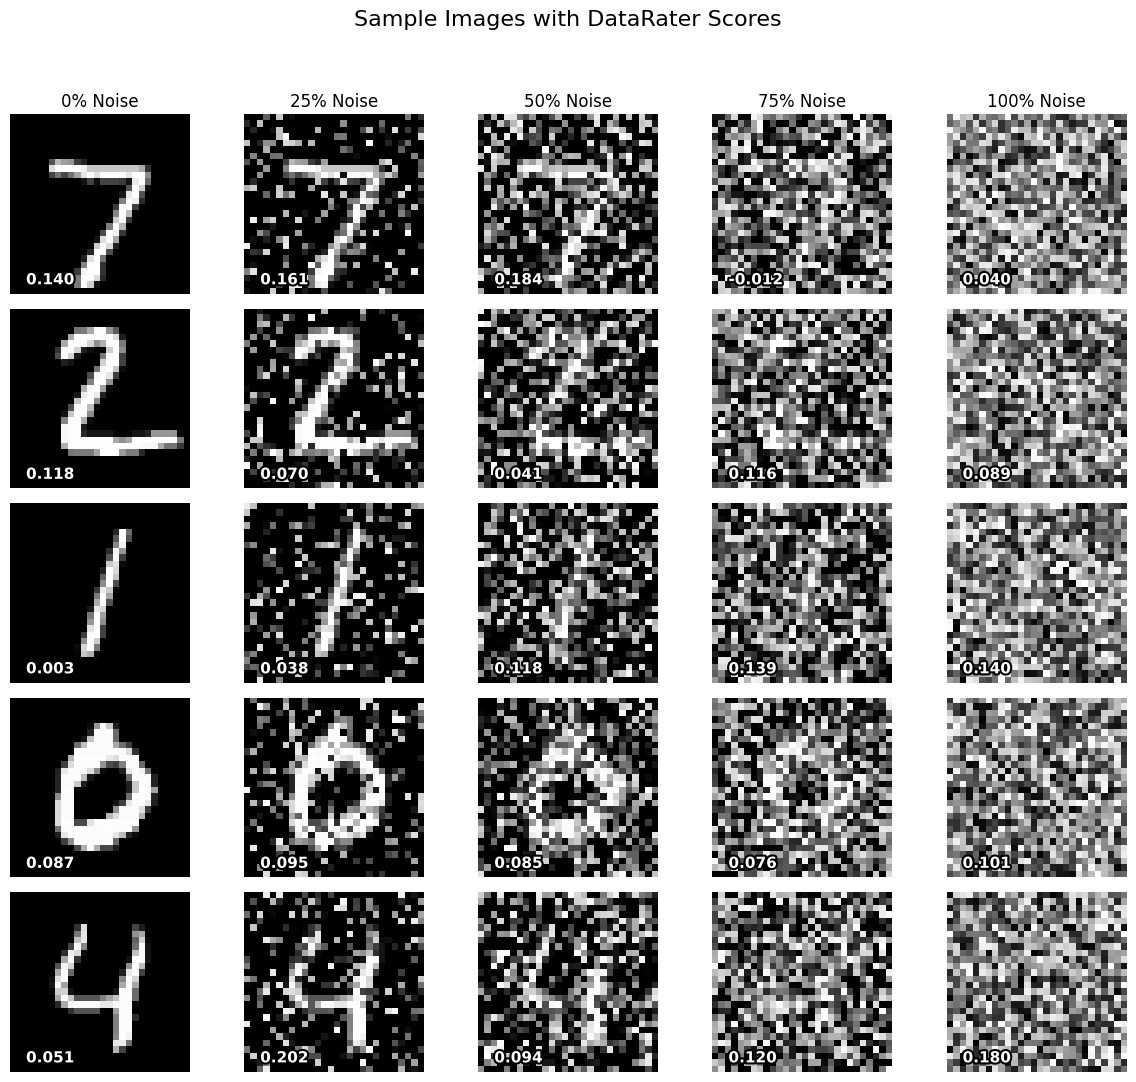

In [24]:
visualize_corruption(trained_data_rater, test_loader, 5)